In [45]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import itertools as it
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import cmath


from finite_groups import *

from activation_funcs import *

In [46]:
# ==============================================================================
# SECTION 1: DEFINE GROUP (G) from Generators
# ==============================================================================
def define_group():
    """
    Define SL(2, F5) via permutations of 24 elements (S24).
    """
    
    # 1. Helper: Parse Cycle Notation string to Tuple (0-indexed)
    def parse_cycle_str(cycle_str, n=24):
        perm = list(range(n))
        clean_str = cycle_str.replace('(', '').replace(')', ' ').strip()
        parts = cycle_str.split('(')
        
        for part in parts:
            if not part.strip(): continue
            nums = [int(x) for x in part.replace(')', '').split()]
            if len(nums) > 1:
                # Create a mapping for this cycle
                mapping = {}
                for i in range(len(nums)):
                    src = nums[i] - 1
                    dst = nums[(i + 1) % len(nums)] - 1
                    mapping[src] = dst
                
                # Apply mapping
                new_perm = perm[:]
                for src, dst in mapping.items():
                    new_perm[src] = dst
                perm = new_perm
        return tuple(perm)

    # 2. Define Multiplication
    def mult_func(p, q):
        return tuple(p[x] for x in q)

    # 3. Input Generators (SL(2,5) generators in S24)
    gen_str_1 = "(1 2 3 4)(5 6 7 8)(9 10 11 12)(13 14 15 16)(17 18 19 20)(21 22 23 24)"
    gen_str_2 = "(1 14 19)(2 11 18)(3 16 17)(4 9 20)(5 6 12)(7 8 10)(13 24 21)(15 22 23)"
    
    generators = [parse_cycle_str(gen_str_1), parse_cycle_str(gen_str_2)]

    # 4. Generate Full Group (Closure)
    print("Generating group elements from generators (BFS)...")
    elements = set(generators)
    queue = deque(generators)
    identity = tuple(range(24))
    if identity not in elements:
        elements.add(identity)
        queue.append(identity)

    while queue:
        current = queue.popleft()
        for g in generators:
            prod = mult_func(current, g)
            if prod not in elements:
                elements.add(prod)
                queue.append(prod)
            
            prod2 = mult_func(g, current)
            if prod2 not in elements:
                elements.add(prod2)
                queue.append(prod2)

    elements_list = list(elements)
    print(f"Group generation complete. Found {len(elements_list)} elements.")
    
    return elements_list, mult_func

# ==============================================================================
# SECTION 2: DEFINE SUBGROUP (H = SL(2,3))
# ==============================================================================
def define_subgroup(G: FiniteGroup):
    """
    Find SL(2,3) (Order 24) inside the generated SL(2,5).
    """
    print("Searching for subgroup of order 24 (SL(2,3))...")
    import random
    target_order = 24
    
    max_attempts = 1000
    for attempt in range(max_attempts):
        # Heuristic: Pick 2 random elements
        gens = random.sample(G.elements, 2)
        
        # Fast Closure using indices
        subset_indices = {G.elem_to_idx[G._key(g)] for g in gens}
        curr_stack = list(subset_indices)
        
        over_limit = False
        while curr_stack:
            curr_idx = curr_stack.pop()
            for g_idx in list(subset_indices):
                prod_idx = G.mult_table[curr_idx, g_idx]
                if prod_idx not in subset_indices:
                    subset_indices.add(prod_idx)
                    curr_stack.append(prod_idx)
                    if len(subset_indices) > target_order:
                        over_limit = True
                        break
            if over_limit: break
            
        if not over_limit and len(subset_indices) == target_order:
            print(f"Subgroup found! Order {len(subset_indices)}")
            H = [G.elements[i] for i in subset_indices]
            return H

    print("Could not find subgroup of order 24. Returning trivial.")
    return [G.identity]

# ==============================================================================
# SECTION 3: CONJUGACY CLASSES
# ==============================================================================
def define_conjugacy_classes():
    """
    We return None to let the solver find the permutation classes automatically.
    The matrix representatives (1,0,0,1) etc provided in your snippet cannot be 
    used here because they are not permutations.
    """
    return None

# ==============================================================================
# SECTION 4: CHARACTER TABLE (MAPPED FROM USER DATA)
# ==============================================================================
def define_character_table(G: FiniteGroup):
    """
    Maps the discovered permutation classes to the provided Matrix Character Table.
    Mapping is done based on element Order.
    """
    
    # --------------------------------------------------------------------------
    # 1) Algebraic numbers used in the table
    # --------------------------------------------------------------------------
    sqrt5 = np.sqrt(5)

    phi_p = (1 + sqrt5) / 2     # (1+√5)/2
    phi_m = (1 - sqrt5) / 2     # (1-√5)/2
    psi_p = (-1 + sqrt5) / 2    # (-1+√5)/2
    psi_m = (-1 - sqrt5) / 2    # (-1-√5)/2

    # --------------------------------------------------------------------------
    # 2) Column data (each list is a column: values across irreps ρ1..ρ9)
    #    Matches the screenshot table.
    # --------------------------------------------------------------------------
    raw_data = {
        # class 1
        "1a":   [1, 2, 2, 3, 3, 4, 4, 5, 6],
        # class 2 (central element -I)
        "2a":   [1, -2, -2, 3, 3, 4, -4, 5, -6],
        # class 3
        "3a":   [1, -1, -1, 0, 0, 1, 1, -1, 0],
        # class 4
        "4a":   [1, 0, 0, -1, -1, 0, 0, 1, 0],
        # class 5A / 5B
        "5a":   [1, psi_p, psi_m, psi_m, psi_p, -1, -1, 0, 1],
        "5b":   [1, psi_m, psi_p, psi_p, psi_m, -1, -1, 0, 1],
        # class 6
        "6a":   [1, 1, 1, 0, 0, 1, 1, -1, 0],
        # class 10A / 10B
        "10a":  [1, phi_p, phi_m, phi_p, phi_m, -1, 1, 0, -1],
        "10b":  [1, phi_m, phi_p, phi_m, phi_p, -1, 1, 0, -1],
    }

    labels = [
        "ρ1 (deg 1)", "ρ2 (deg 2)", "ρ3 (deg 2)",
        "ρ4 (deg 3)", "ρ5 (deg 3)", "ρ6 (deg 4)",
        "ρ7 (deg 4)", "ρ8 (deg 5)", "ρ9 (deg 6)",
    ]

    # --------------------------------------------------------------------------
    # 3) Helper: compute element order from multiplication table
    # --------------------------------------------------------------------------
    def element_order(rep_idx: int, safety_cap: int = 500) -> int:
        if rep_idx == G.identity_idx:
            return 1
        curr = rep_idx
        k = 1
        while curr != G.identity_idx and k < safety_cap:
            curr = G.mult_table[curr, rep_idx]
            k += 1
        return k

    # --------------------------------------------------------------------------
    # 4) Bucket discovered conjugacy classes by order
    # --------------------------------------------------------------------------
    classes_by_order = {}
    for cls in G.classes:
        rep_idx = G.elem_to_idx[G._key(cls.representative)]
        ord_rep = element_order(rep_idx)
        classes_by_order.setdefault(ord_rep, []).append(cls)

    def pop_class(order: int):
        lst = classes_by_order.get(order, [])
        return lst.pop(0) if lst else None

    # --------------------------------------------------------------------------
    # 5) Map discovered classes to the abstract columns by order.
    #    Note: for orders 5 and 10 there are TWO classes; we assign in discovery order.
    #    If your discovered ordering is swapped, you'll get A/B swapped (a relabelling).
    # --------------------------------------------------------------------------
    char_map = {}

    c = pop_class(1)
    if c: char_map[c.representative] = raw_data["1a"]

    c = pop_class(2)
    if c: char_map[c.representative] = raw_data["2a"]

    c = pop_class(3)
    if c: char_map[c.representative] = raw_data["3a"]

    c = pop_class(4)
    if c: char_map[c.representative] = raw_data["4a"]

    c = pop_class(6)
    if c: char_map[c.representative] = raw_data["6a"]

    # Order 5: two classes
    c1 = pop_class(5)
    c2 = pop_class(5)
    if c1: char_map[c1.representative] = raw_data["5a"]
    if c2: char_map[c2.representative] = raw_data["5b"]

    # Order 10: two classes
    d1 = pop_class(10)
    d2 = pop_class(10)
    if d1: char_map[d1.representative] = raw_data["10a"]
    if d2: char_map[d2.representative] = raw_data["10b"]

    return char_map, labels

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================
def run_analysis():
    print(">>> 1. Loading Group Data...")
    elements, mult_func = define_group()
    
    G = FiniteGroup(elements, mult_func, classes=define_conjugacy_classes())
    print(f"    Group Order: {G.n} (Expected 120)")
    print(f"    Classes Found: {len(G.classes)} (Expected 9)")
    
    print("\n>>> 2. Loading Subgroup Data...")
    H_elements = define_subgroup(G)
    
    if len(H_elements) == 1:
        print("Skipping induced rep (no valid subgroup found).")
        return

    solver = InducedRepSolver(G)
    solver.set_subgroup(H_elements)
    
    print("\n>>> 3. Loading Character Table (Auto-Map)...")
    char_map, labels = define_character_table(G)
    solver.load_character_table(char_map, irrep_labels=labels)
    
    print("\n>>> 4. Computing Exact Projectors (SymPy)...")
    solver.compute_projectors()
    
    print("\n>>> 5. Induced Representation Decomposition:")
    for label, Q in solver.Qblocks.items():
        if Q.shape[1] > 0:
            print(f"    Irrep '{label}' appears with dimension {Q.shape[1]}")
    
    print("\n>>> 6. Building Interaction Graph...")
    def relu_sym(x): return sp.Max(0, x)
    def tanh_sym(x): return (sp.exp(x) - sp.exp(-x)) / (sp.exp(x) + sp.exp(-x))
    def sigmoid_sym(x): return 1 / (1 + sp.exp(-x))
    
    graph = solver.build_interaction_graph(activation_fn=sigmoid_sym, verbose=True)
    print(f"    Edges found: {graph.edges()}")
    
    if len(graph.nodes) > 0:
        plt.figure(figsize=(10,10))
        pos = nx.spring_layout(graph, seed=42)
        nx.draw_networkx(graph, pos, node_color="#E8F0FF", edgecolors="blue", 
                         node_size=2000, font_weight="bold", with_labels=True)
        plt.show()

>>> 1. Loading Group Data...
Generating group elements from generators (BFS)...
Group generation complete. Found 120 elements.
Building multiplication table for G (order 120)...
Discovering conjugacy classes...
    Group Order: 120 (Expected 120)
    Classes Found: 9 (Expected 9)

>>> 2. Loading Subgroup Data...
Searching for subgroup of order 24 (SL(2,3))...
Subgroup found! Order 24
Computed 5 cosets for H (order 24) in G (order 120).

>>> 3. Loading Character Table (Auto-Map)...
Character table loaded (SymPy).

>>> 4. Computing Exact Projectors (SymPy)...

>>> 5. Induced Representation Decomposition:
    Irrep 'ρ1 (deg 1)' appears with dimension 1
    Irrep 'ρ6 (deg 4)' appears with dimension 4

>>> 6. Building Interaction Graph...
Irreps present: ['ρ1 (deg 1)', 'ρ6 (deg 4)']
    Edges found: [('ρ1 (deg 1)', 'ρ1 (deg 1)'), ('ρ6 (deg 4)', 'ρ1 (deg 1)'), ('ρ6 (deg 4)', 'ρ6 (deg 4)')]


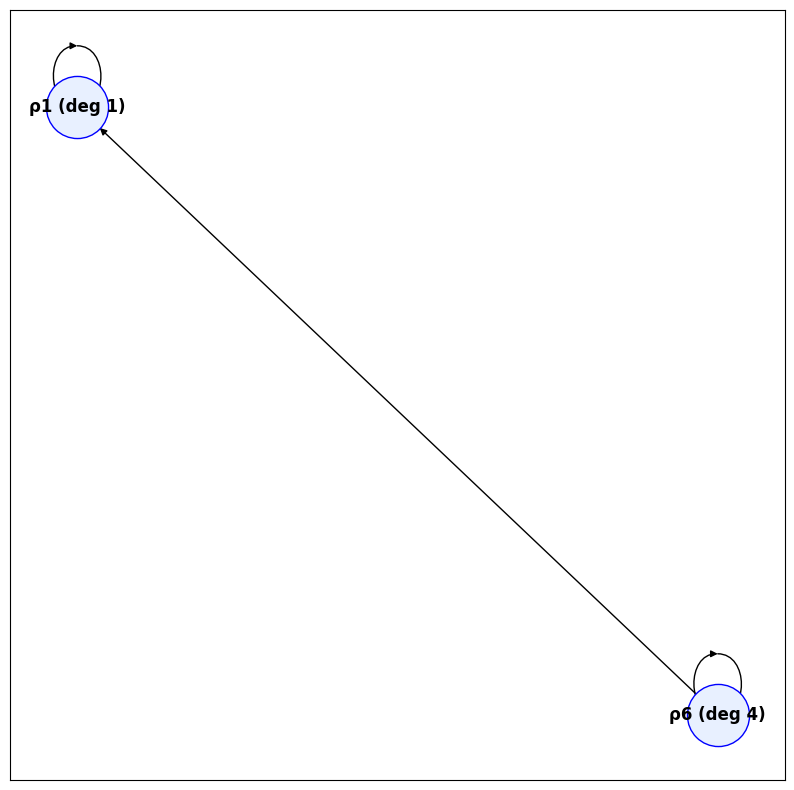

In [47]:
run_analysis()